In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
%matplotlib inline
tf.__version__

'2.2.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive'

/content/drive/My Drive


In [ ]:
os.getcwd()

'/content/drive/My Drive'

In [ ]:
data_dir=os.path.join(os.getcwd(),'Swedish Leaf')

Splitting the Dataset into Train,Test and Validation Sets

In [ ]:
image_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [ ]:
train_dataset=image_generator.flow_from_directory(
    batch_size=64,
    directory=data_dir,
    shuffle=True,
    target_size=(128,128),
    subset='training',
    class_mode='categorical'
)

Found 4800 images belonging to 15 classes.


In [ ]:
val_dataset=image_generator.flow_from_directory(
    batch_size=64,
    directory=data_dir,
    shuffle=True,
    target_size=(128,128),
    subset='validation',
    class_mode='categorical'


)

Found 1200 images belonging to 15 classes.


In [ ]:
test_dir=os.path.join(os.getcwd(),'local')

In [ ]:
test_generator=ImageDataGenerator(rescale=1./255)

In [ ]:
test_dataset=test_generator.flow_from_directory(
    batch_size=64,
    directory=test_dir,
    target_size=(128,128),
    class_mode='categorical'

)

Found 1125 images belonging to 15 classes.


Visualizing Some Images From Train Dataset

In [ ]:
sample_training_images,labels=next(train_dataset)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

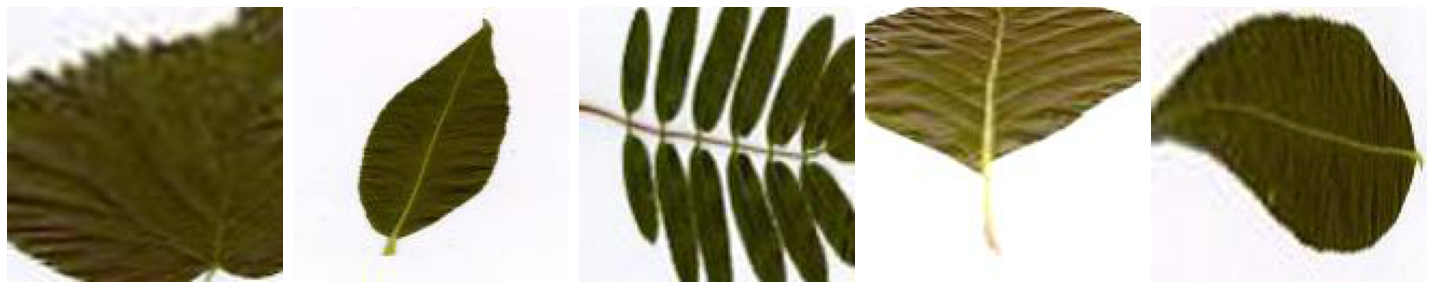

In [ ]:
#Plotting some Samples from the Train Set
plotImages(sample_training_images[:5])

Defining the Convolutional Model

In [ ]:
strategy=tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [ ]:
with strategy.scope():
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(5,5),strides=(1,1),padding='same',activation='relu',input_shape=[128,128,3]))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'))
  
  model.add(tf.keras.layers.Conv2D(64,(5,5),activation='relu',padding='same',strides=(1,1)))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv2D(96,(3,3),activation='relu',strides=(2,2),padding='same'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='valid'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=100,activation='relu'))
  model.add(tf.keras.layers.Dense(units=100,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Dense(15,activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])




 

In [ ]:
history=model.fit(train_dataset,epochs=20,validation_data=val_dataset,verbose=1)

Epoch 1/20
75/75 [==============================] - 2566s 34s/step - accuracy: 0.2656 - loss: 2.2691 - val_accuracy: 0.1442 - val_loss: 2.5796
Epoch 2/20
75/75 [==============================] - 11s 153ms/step - accuracy: 0.4310 - loss: 1.6647 - val_accuracy: 0.1517 - val_loss: 2.7223
Epoch 3/20
75/75 [==============================] - 10s 136ms/step - accuracy: 0.5469 - loss: 1.3040 - val_accuracy: 0.0808 - val_loss: 4.1511
Epoch 4/20
75/75 [==============================] - 10s 135ms/step - accuracy: 0.6256 - loss: 1.0554 - val_accuracy: 0.2383 - val_loss: 2.8728
Epoch 5/20
75/75 [==============================] - 10s 135ms/step - accuracy: 0.7035 - loss: 0.8431 - val_accuracy: 0.3150 - val_loss: 2.7947
Epoch 6/20
75/75 [==============================] - 10s 135ms/step - accuracy: 0.7340 - loss: 0.7318 - val_accuracy: 0.3525 - val_loss: 2.6343
Epoch 7/20
75/75 [==============================] - 10s 134ms/step - accuracy: 0.7969 - loss: 0.5821 - val_accuracy: 0.5292 - val_loss: 1.7027

Plotting Training vs Validation Accuracy and Loss 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

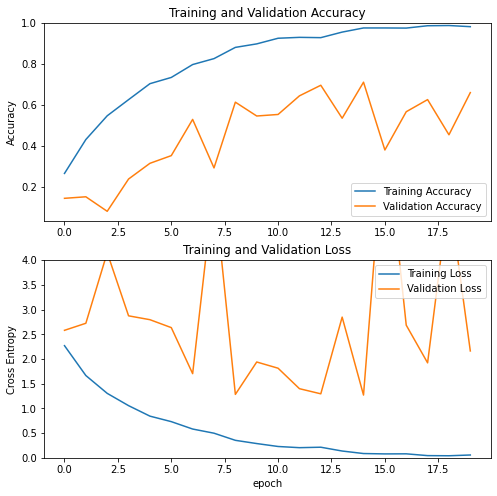

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluating the Model on the Test Set

In [ ]:
test_loss,test_accuracy=model.evaluate(test_dataset)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [ ]:
print('Test Loss : ',test_loss)
print('Test_Accuracy: ',test_accuracy)

Test Loss :  0.4604036509990692
Test_Accuracy:  0.902222216129303


We got accuracy of 90% on Test Dataset

In [ ]:
#Saving the Model Architecture and weights
model.save('my_model.h5')

In [ ]:
model.save_weights('my_model_weights.h5')